# Solving a PDE in complex geometries with the smoothed boundary method.

We have also included functionality for solving PDEs in arbitrary geometries using the smoothed boundary method. We demonstrate with the 2D Allen-Cahn equation in this example.

In [ ]:
import jax.numpy as jnp
import numpy as np
from jax import random
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation
import diffrax as dfx
from PIL import Image
import numpy as np

from pde_opt.numerics.domains import Domain
from pde_opt.numerics.shapes import Shape
from pde_opt.numerics.equations.allen_cahn import AllenCahn2DSmoothedBoundary
from pde_opt.pde_model import PDEModel

In [71]:
# Load image and convert to grayscale
img = Image.open('../cool_smile.png').convert('L')

# Convert to numpy array and binarize
img_array = np.array(img)
binary = (img_array > 128).astype(np.float32)  # Threshold at 128

# Convert to jax array
binary_mask = jnp.array(binary)


In [72]:
shape = Shape(
    binary=jnp.array(binary_mask),
    dx=(1.0, 1.0),
    smooth_epsilon=3.0,
    smooth_curvature=0.008,
    smooth_dt=0.01,
    smooth_tf=100.0,
)

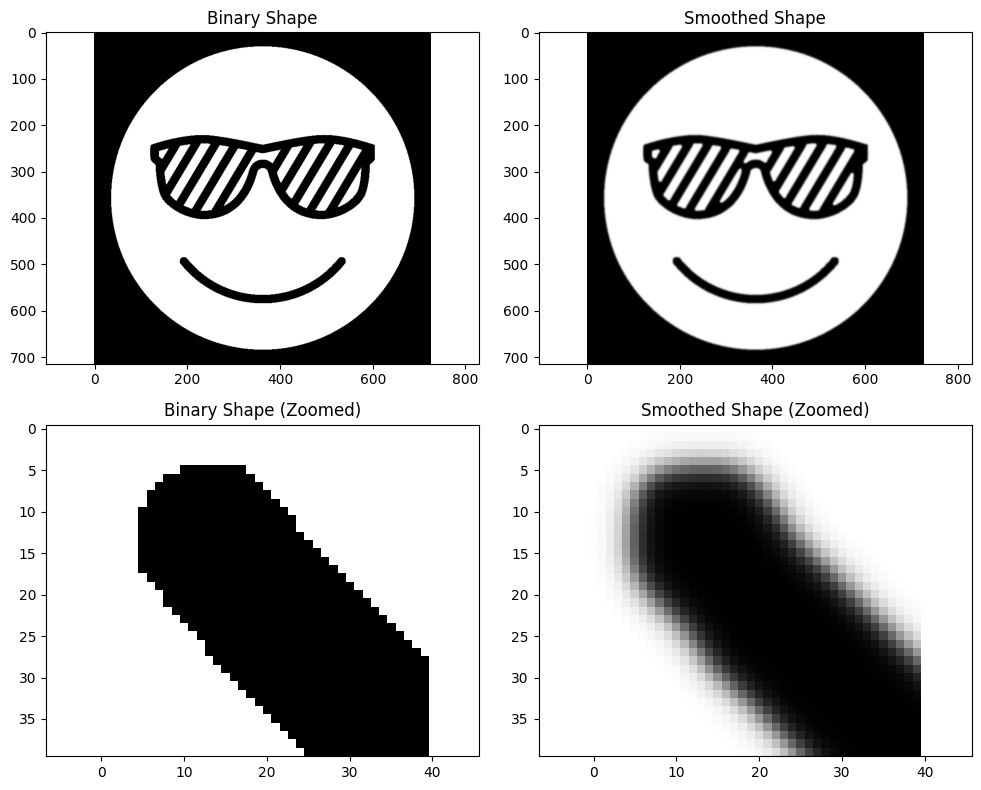

In [73]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

ax1.imshow(shape.binary, cmap='gray')
ax1.set_title('Binary Shape')
ax1.axis('equal')

ax2.imshow(shape.smooth, cmap='gray') 
ax2.set_title('Smoothed Shape')
ax2.axis('equal')

ax3.imshow(shape.binary[480:520, 180:220], cmap='gray')
ax3.set_title('Binary Shape (Zoomed)')
ax3.axis('equal')

ax4.imshow(shape.smooth[480:520, 180:220], cmap='gray')
ax4.set_title('Smoothed Shape (Zoomed)')
ax4.axis('equal')

plt.tight_layout()
plt.show()

While not used in this example, we can also compute the eigenvectors of the graph Laplacian that make up the geometry.
This is useful if performing some optimization where when parameter is a function on the domain.
You can get an orthornormal basis for the domain using the eigenvectors of the graph Laplacian.

Here, we compute and visualize what these shape modes look like.

In [ ]:
shape.get_shape_modes(N=36)

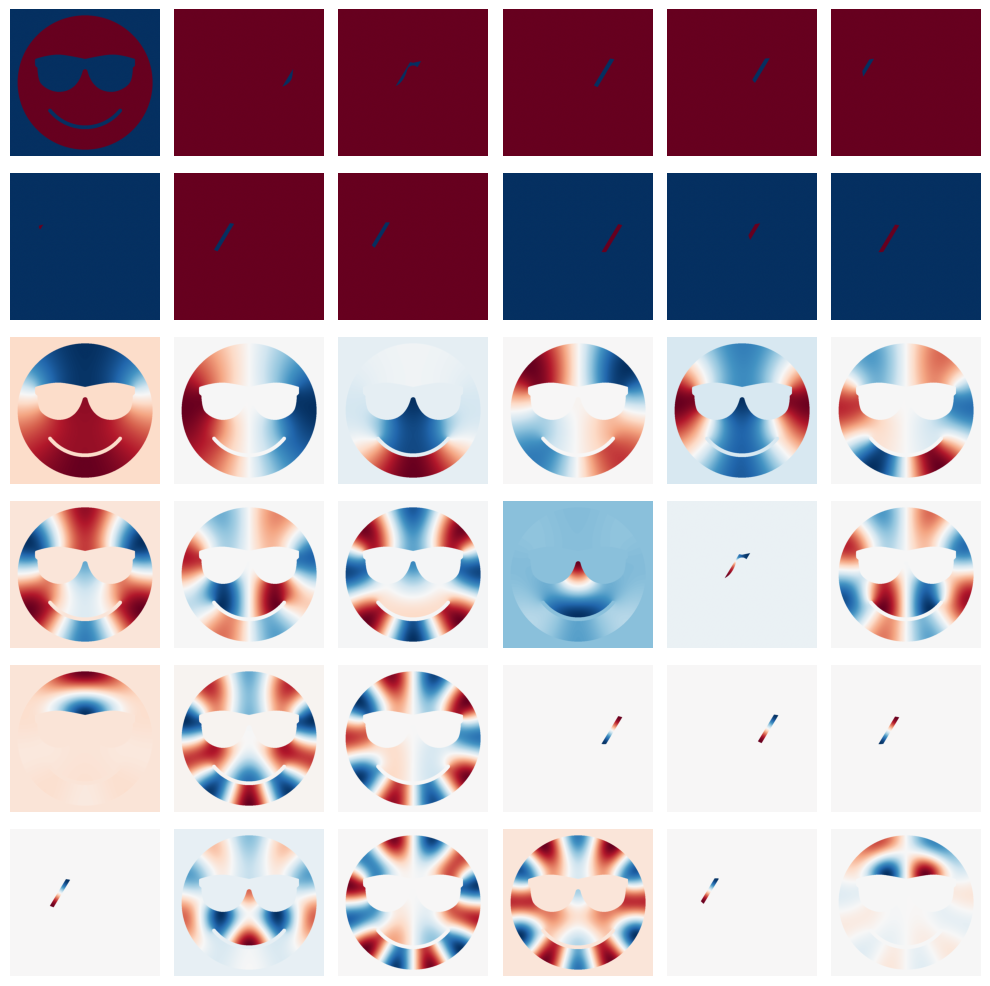

In [77]:
# Plot shape modes
fig, axes = plt.subplots(6, 6, figsize=(10, 10))
axes = axes.flatten()

for i in range(36):
    axes[i].imshow(shape.shape_basis[:, :, i], cmap="RdBu")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [82]:
Nx, Ny = binary_mask.shape
Lx = 0.01 * Nx
Ly = 0.01 * Ny

domain = Domain(
    (Nx, Ny), ((-Lx / 2, Lx / 2), (-Ly / 2, Ly / 2)), "dimensionless", shape
)



In [83]:
model = PDEModel(AllenCahn2DSmoothedBoundary, domain, dfx.Tsit5)

In [84]:
t_start = 0.0
t_final = 20.0
dt = 0.000001
ts_save = jnp.linspace(t_start, t_final, 200)

In [85]:
pde_parameters = {
    "kappa": 0.002,
    "f": lambda c: c * jnp.log(c) + (1.0 - c) * jnp.log(1.0 - c) + 3.0 * c * (1.0 - c) + 0.059,
    "mu": lambda c: jnp.log(c / (1.0 - c)) + 3.0 * (1.0 - 2.0 * c),
    "R": lambda c: (1.0 - c) * c,
    "theta": lambda t: jnp.pi / 2.0,
    "derivs": "fd"
}


In [86]:
key = random.PRNGKey(0)
u0 = 0.5 * jnp.ones((Nx, Ny)) + 0.1 * random.normal(key, (Nx, Ny))

In [88]:
solution = model.solve(
    pde_parameters,
    u0,
    ts_save,
    stepsize_controller=dfx.PIDController(rtol=1e-4, atol=1e-6)
)

In [99]:
fig, ax = plt.subplots(figsize=(4,4))

ims = []
for i in range(0, len(solution), 10):
    im = ax.imshow(solution[i] * domain.geometry.binary, animated=True, 
                   vmin=0.0, vmax=1.0,
                   extent=[domain.box[0][0], domain.box[0][1], 
                          domain.box[1][0], domain.box[1][1]])
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True)

plt.title('Allen-Cahn Evolution with Smoothed Boundary')
plt.xlabel('x')
plt.ylabel('y')

plt.close()

HTML(ani.to_jshtml())